In [66]:
### BASIC
import numpy as np # for arrays
import pandas as pd # for panel data
import geopandas as gpd
import random # for random number generation
import matplotlib.pyplot as plt
import os # miscellaneous operating system interfaces

In [67]:
def remove_inexact(data): 
    '''
    function to remove inexact coordinates
    i.e., the cooridnates Google Maps returns when searching for "Sweden", etc.
    '''
    
    # Sweden
    data.loc[(data['latitude'] == 60.12816100000001 ) & (data['longitude'] == 18.643501), 
             ['latitude', 'longitude']] = 'None'
    # Norrbotten
    data.loc[(data['latitude'] == 66.8309216 ) & (data['longitude'] == 20.3991966), 
             ['latitude', 'longitude']] = 'None'
    # Västernorrland
    data.loc[(data['latitude'] == 63.4276473 ) & (data['longitude'] == 17.7292444), 
             ['latitude', 'longitude']] = 'None'
    # Västra Götaland
    data.loc[(data['latitude'] == 58.2527926 ) & (data['longitude'] == 13.0596425), 
             ['latitude', 'longitude']] = 'None'
    # Västerbotten
    data.loc[(data['latitude'] == 65.3337311 ) & (data['longitude'] == 16.5161694), 
             ['latitude', 'longitude']] = 'None'

    return(data)

In [68]:
def geopandas_join(county_code, county_id):
    '''
    function to load, clean, geojoin Google Maps API results
    '''
    
    ### LOAD DATA
    
    # set file location
    location = "./data/" + str(county_code) + "/results_API_" + str(county_code) + "_clean.csv"
    # load data
    data = pd.read_csv(location)
    # number of observations
    obs = data.shape[0]
    
    ### CLEAN DATA
    
    # remove inexact observations
    data = remove_inexact(data=data)
    # remove observations w/out coordinates and those not in Sweden, Norwway, or Finland
    data = data.loc[(data['latitude'] != "None") | 
                    (data['longitude'] != "None")]
    data = data.loc[(data['country_API'] == "Sweden") | 
                    (data['country_API'] == "Norway") | 
                    (data['country_API'] == "Finland")]

    ### JOIN DATA
    
    # turn dataframe into coordinates
    points = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude),crs='epsg:4326')
    # load shapefile of Swedish parishes (in year 1820)
    hist_shp = gpd.read_file('./data/geo/SE_parishes.shp')
    # merge dataframes
    dfsjoin = gpd.sjoin(hist_shp, points)
    
    ### RESULTS
    
    # % located
    percent_loc = dfsjoin[(dfsjoin["county"] == county_id)].shape[0]/obs
    print("% Located:", round(percent_loc,3))
    # % match with hand-coded
    dfsjoin2 = dfsjoin[dfsjoin["parish_search"] != "Not identified"]
    dfsjoin2 = dfsjoin2[dfsjoin2["county"] == county_id]
    dfsjoin2['compare'] = (dfsjoin2["socken"] == dfsjoin2["parish_search"])
    percent_match = dfsjoin2['compare'].sum()/dfsjoin2.shape[0]
    print("% Match:", round(percent_match,3))
    
    return(hist_shp, points, dfsjoin)


In [69]:
hist_shp, points, dfsjoin = geopandas_join(county_code = "ac", county_id = 24)

% Located: 0.833
% Match: 0.759


In [80]:
def point_count_map(hist_shp, points, dfsjoin, county_id):
    '''
    function to find obs. per parish and map results
    '''
    
    # calculate number of observations by parish
    point_count = dfsjoin.socken.value_counts().reset_index().\
    rename(columns={'index':'socken','socken':'point_count'})
    
    # merge point count with shapefile
    hist_shp = hist_shp.merge(point_count, on='socken', how='left')
    
    # fill missing values
    hist_shp['point_count'].fillna(0, inplace=True)
    
    # implied density per km2 - could also plot this
    hist_shp['point_count_area'] =  hist_shp['point_count']/hist_shp['area']
    
    # restrict to county under investigation
    hist_shp = hist_shp[hist_shp['county'] == county_id]
    
    # load county layer
    county_shp = gpd.read_file('./data/geo/SE_counties.shp')
    
    ### MAP
    
    fig, ax = plt.subplots(figsize=(20,20))
    # counties
    county_shp.plot(ax=ax, fc="lightgrey", ec="black", alpha=1)
    # parishes
    hist_shp.plot(ax=ax ,column='point_count',legend=True, cmap=plt.get_cmap("RdYlBu_r"), ec="black")
    # points
    points.plot(ax=ax,markersize=0.5, color='black')
    ax.axis('off')

    # returning point count for reference
    return(point_count)
    

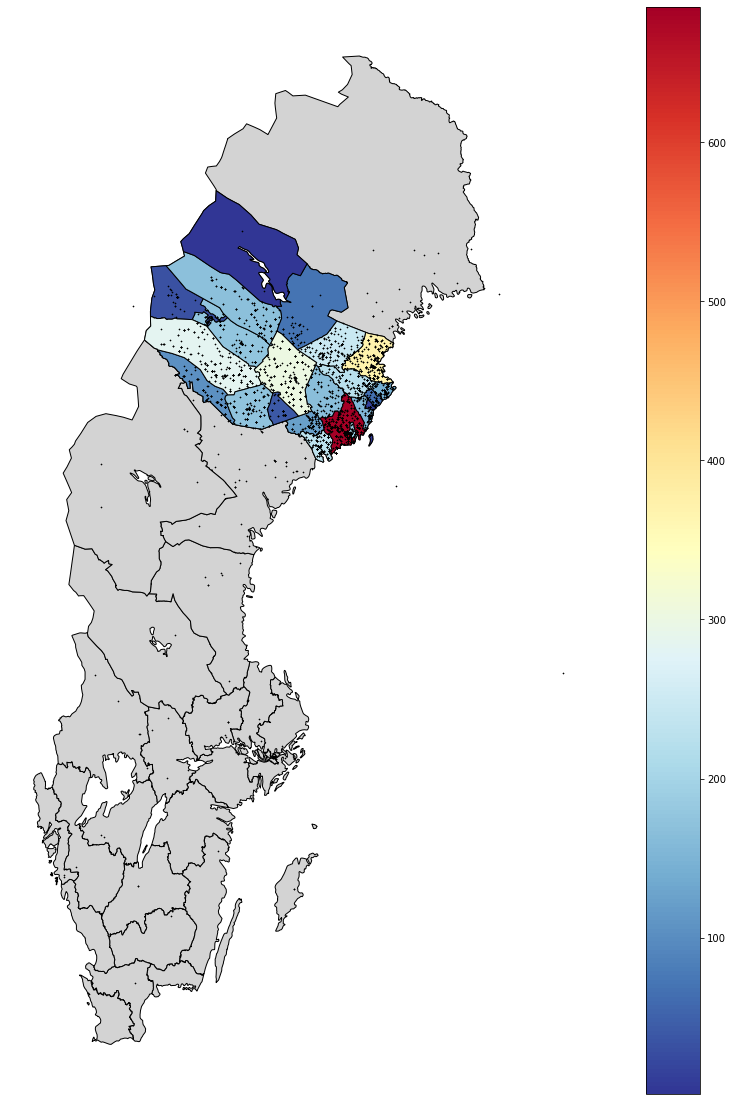

In [81]:
point_count = point_count_map(hist_shp=hist_shp, points=points, dfsjoin=dfsjoin, county_id=24)